In [1]:
import stim
import sinter
from qldpc.stim.util import Basis, _det_basis_parity
from qldpc.stim.sinter_decoders import BPLSD

### CSS Decoding with Sinter

In [2]:
d = 7
p = 3e-3

surface_code_circ = stim.Circuit.generated('surface_code:rotated_memory_z', distance=d, rounds=d, after_clifford_depolarization=p, before_measure_flip_probability=p)

In [3]:

tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d,
            distance=d,
            after_clifford_depolarization=p, before_measure_flip_probability=p
        ),
        json_metadata={'d': d, 'p': p},
    )
    for d in [3, 5, 7]
    for p in [3e-3, 5e-3, 1e-2]
]

In [4]:
results = sinter.collect(
    num_workers=4,
    max_shots=10**6,
    max_errors=100,
    tasks=tasks,
    decoders=['bplsd'],
    custom_decoders={'bplsd': BPLSD(Basis.Z, fn_det_basis=_det_basis_parity, max_iter=30, bp_method="ms", lsd_method = 'lsd_cs', lsd_order = 0)}
)

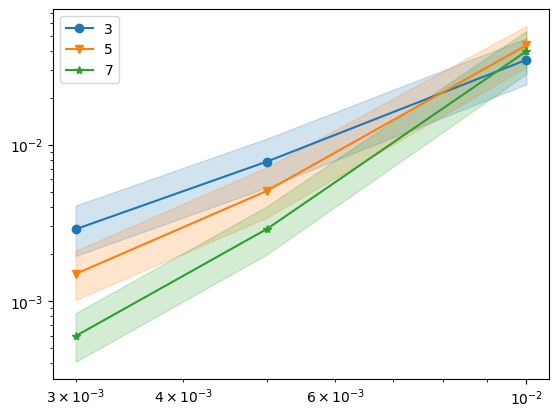

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=results,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.legend()